# **Github**

In [2]:
# 해당 폴더로 이동
%cd /content/drive/MyDrive/Colab\ Notebooks/Github/IndividualProject-CompareDrawingStyle/CompareDrawingStyle

# 본인 확인
!git config --global user.email "lightcloud98@gmail.com"
!git config --global user.name "ddophi98"

# 바꾼 파일 add
!git add CompareDrawingStyle.ipynb

# 커밋하고 푸쉬
!git commit -m "이미지 비교를 위해 average hash 활용"
!git push

/content/drive/MyDrive/Colab Notebooks/Github/IndividualProject-CompareDrawingStyle/CompareDrawingStyle
[main 597f119] 이미지 비교를 위해 average hash 활용
 1 file changed, 1 insertion(+), 1 deletion(-)
 rewrite CompareDrawingStyle.ipynb (95%)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 2 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 209.72 KiB | 8.74 MiB/s, done.
Total 3 (delta 0), reused 0 (delta 0)
To https://github.com/ddophi98/CompareDrawingStyle.git
   ed8a527..597f119  main -> main


# **드라이브 연결**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **라이브러리 다운 및 임포트**

In [ ]:
from PIL import Image

import pickle as pk
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

plt.rc('font', family='NanumBarunGothic') 

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-nanum is already the newest version (20180306-3).
The following package was automatically installed and is no longer required:
  libnvidia-common-510
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 21 not upgraded.
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/share/fonts/truetype/nanum: caching, new cache contents: 10 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: skipping, no such directory
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-san

# **전역 변수**

In [ ]:
# 폴더 이름
data_path = "/content/drive/MyDrive/Colab Notebooks/Github/IndividualProject-CompareDrawingStyle/Data/"
webtoon_thumbnails_path = data_path+"naver_webtoon_thumbnails/"
images_style_path = data_path+"images_style/"

# 파일 이름
images_style_filename = data_path+"images_style.pickle"

# **유틸리티**

In [ ]:
# 폴더 만들기
def make_dir(dir_path):
    if not os.path.isdir(dir_path):
        os.makedirs(dir_path)
        return True
    return False

# 특정 데이터를 파일에 저장해놓기 (Pickle)
def save_data(filename, data):
    with open(filename, 'wb') as f:
        pk.dump(data, f)

# 저장해둔 데이터 불러오기 (Pickle)
def load_data(filename):
    with open(filename, 'rb') as f:
        return pk.load(f)

# 폴더로부터 이미지 가져오기 (Pillow)
def get_images_from_folder(folder_path):
    min_width = 9999
    min_height = 9999
    file_list = sorted(os.listdir(folder_path))
    images = []
    image_names = []

    for file in file_list:
        img = Image.open(folder_path+file).convert("RGB")
        img_np = np.array(img)
        images.append(img_np)
        image_names.append(file)

        min_width = min(min_width, img_np.shape[1])
        min_height = min(min_height, img_np.shape[0])

    return images, image_names, min_width, min_height

# 폴더에 이미지 저장하기 (Pillow)
def save_image_to_folder(folder_path, img_name, img):
    img_name.replace("/", "")

    if not os.path.isfile(folder_path+img_name):
        img.save(folder_path+img_name, img_name[-3:].upper())

# numpy로 이루어진 이미지를 원하는 사이즈로 조절하기
def resize_image(image_np, width, height):
    img_shape = image_np.shape
    h_width = width // 2
    h_height = height // 2
    x_center = img_shape[1] // 2
    y_center = img_shape[0] // 2
    resized_image = image_np[(y_center-h_height):(y_center+h_height), (x_center-h_width):(x_center+h_width)]
    return resized_image

# numpy 이미지를 pillow 이미지로 변환하기
def numpy_to_pilow(numpy_img):
    return Image.fromarray((numpy_img*255).astype(np.uint8))

# numpy 이미지를 rgb에서 grayscale로 변환하기
def rgb_to_grayscale(numpy_img):
    return np.dot(numpy_img[...,:3], [0.2989, 0.5870, 0.1140])

# **데이터 불러오기**

In [ ]:
target_images, target_images_names, min_width, min_height = get_images_from_folder(webtoon_thumbnails_path)
target_images = [resize_image(img, min_width, min_height) for img in target_images]

# **스타일 추출**

In [ ]:
style_layers = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']
content_layers = ['block5_conv2']

# 스타일 추출하는 모델
class StyleContentModel(tf.keras.models.Model):
    def __init__(self):
        super(StyleContentModel, self).__init__()
        self.vgg = self.vgg_layers(style_layers + content_layers)
        self.vgg.trainable = False

    # vgg 모델 불러오기
    def vgg_layers(self, layer_names):
        # 이미지넷 데이터셋에 사전학습된 VGG 모델 불러오기
        vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
        vgg.trainable = False

        outputs = [vgg.get_layer(name).output for name in layer_names]

        model = tf.keras.Model([vgg.input], outputs)
        return model

    # 스타일을 뽑아내기 위한 그람 행렬
    def gram_matrix(self, input_tensor):
        result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
        input_shape = tf.shape(input_tensor)
        num_locations = tf.cast(input_shape[1] * input_shape[2], tf.float32)
        return result / num_locations

    def call(self, inputs):
        # "[0,1] 사이의 실수 값을 입력으로 받습니다"
        inputs = inputs * 255.0
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        outputs = self.vgg(preprocessed_input)
        style_outputs, content_outputs = (outputs[:len(style_layers)],
                                          outputs[len(style_layers):])

        style_outputs = [self.gram_matrix(style_output)
                         for style_output in style_outputs]

        content_dict = {content_name: value
                        for content_name, value
                        in zip(content_layers, content_outputs)}

        style_dict = {style_name: value
                      for style_name, value
                      in zip(style_layers, style_outputs)}

        return {'content': content_dict, 'style': style_dict}

In [ ]:
# 일부 데이터만 학습을 시키면서 스타일 추출해내고 이미지로 결과 보여주기
def extract_and_show_style(indexes, style_images, train_n):

    style_images = [style_images[index] for index in indexes]
    content_image = np.ones((1, min_height, min_width, 3))
    extractor = StyleContentModel()
    opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

    # 텐서플로 변수의 구조를 정하기 위해 임시로 초기화
    tf_image = tf.Variable(tf.ones_initializer()(shape=[1, min_height, min_width, 3], dtype=tf.float32))

    for i, style_image in enumerate(style_images):
        style_image = style_image.reshape(1, min_height, min_width, 3)
        style_image = np.divide(style_image, 255)
        
        style_targets = extractor.call(style_image)['style']
        content_targets = extractor.call(content_image)['content']
        tf_image.assign(content_image)

        squeezed_img = np.array(style_image).squeeze()

        plt.subplot(1, 2, 1)
        plt.imshow(squeezed_img)
        plt.title("target")

        for step in range(train_n):
            print("\r" + str(step + 1) + "/" + str(train_n), end="")
            train_step(image=tf_image,
                            style_targets=style_targets,
                            content_targets=content_targets,
                            opt=opt,
                            extractor=extractor)

        result_image = np.array(tf_image).squeeze()
        
        plt.subplot(1, 2, 2)
        plt.imshow(result_image)
        plt.title("result")

        plt.show()


# 학습을 시키면서 스타일 추출해내기
def extract_style(style_images, train_n):

    content_image = np.ones((1, min_height, min_width, 3))
    extractor = StyleContentModel()
    opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

    # 텐서플로 변수의 구조를 정하기 위해 임시로 초기화
    tf_image = tf.Variable(tf.ones_initializer()(shape=[1, min_height, min_width, 3], dtype=tf.float32))

    trained_images = []
    for i, style_image in enumerate(style_images):
        print("\r" + str(i + 1) + "/" + str(len(style_images)) + "  " + target_images_names[i], end="")

        style_image = style_image.reshape(1, min_height, min_width, 3)
        style_image = np.divide(style_image, 255)

        style_targets = extractor.call(style_image)['style']
        content_targets = extractor.call(content_image)['content']
        tf_image.assign(content_image)

        for step in range(train_n):
            train_step(image=tf_image,
                            style_targets=style_targets,
                            content_targets=content_targets,
                            opt=opt,
                            extractor=extractor)

        result_image = np.array(tf_image).squeeze()
        trained_images.append(result_image)

    return trained_images

# 스타일 학습시킬 때 쓸 loss 함수
def style_content_loss(outputs, style_targets, content_targets):
    style_weight = 1e4
    content_weight = 1e-2

    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2)
                            for name in style_outputs.keys()])
    style_loss *= style_weight / len(style_layers)

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2)
                                for name in content_outputs.keys()])
    content_loss *= content_weight / len(content_layers)
    loss = style_loss + content_loss
    return loss

# 픽셀 값이 실수이므로 0과 1 사이의 값으로 바꾸기
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

# 학습하기
@tf.function()
def train_step(image, style_targets, content_targets, opt, extractor):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = style_content_loss(
            outputs=outputs,
            style_targets=style_targets,
            content_targets=content_targets
        )
    grad = tape.gradient(loss, image)
    opt.apply_gradients([(grad, image)])
    image.assign(clip_0_1(image))

In [ ]:
print(target_images_names)

['100.png', '102030.png', '108명의 그녀들.png', '10월 27일.png', '10월 28일.png', '11me.png', '12차원 소년들.png', '1331.png', '17살, 그 여름날의 기적.png', '1을 줄게.png', '1인용 기분.png', '1초.png', '1학년 9반.png', '2-3승강장.png', '2011 루키 단편선.png', '2011 미스테리 단편.png', '2012 루키 단편선.png', '2012 지구가 멸망한다면_.png', '2013 루키 단편선.png', '2013 전설의고향.png', '2014 네이버 웹툰, 왓 이프_.png', '2014 루키 단편선.png', '2015 루키 단편선.png', '2015 사이.png', '2015 소름.png', '2015 우주특집 단편.png', '2016 루키 단편선.png', '2016 비명.png', '2016 학교 다녀오겠습니다.png', '2017 루키 단편선.png', '2017 멋진 신세계.png', '2017 사이다를 부탁해!.png', '2018 루키 단편선.png', '2018 재생금지.png', '2019 귀신사용설명서 - 괴담의 재구성.png', '2019 루키 단편선.png', '2019 병영일기.png', '2020 최애캐의 MBTI.png', '2020 호랑 공포 단편선.png', '2021 최애캐 안녕, 잘 지내니_.png', 

In [ ]:
# 스타일 추출 테스트
# 
titles = ["독립일기", "대학일기", "수능일기", "놓정동화", "놓지마 정신줄 시즌2", "놓지마 정신줄"]
title_indexes = [target_images_names.index(title+".png") for title in titles]
extract_and_show_style(title_indexes, target_images, 1000)

In [ ]:
# 훈련으로 스타일 추출하거나 이미 추출한 이미지 가져오기
if not os.path.isfile(images_style_filename):
    images_style = extract_style(target_images, 1000)
    save_data(images_style_filename, images_style)
else:
    images_style = load_data(images_style_filename)

# 눈으로 확인하기 위해 추출한 이미지들을 폴더에 저장하기
if make_dir(images_style_path):
    for i, img in enumerate(images_style):
        pil_image = numpy_to_pilow(img)
        save_image_to_folder(images_style_path, target_images_names[i][:-4] + "_style.png", pil_image)

# **이미지 비교**

In [ ]:
# 이미지 데이터를 Average Hash로 변환하기
def average_hash(numpy_img):
    pil_img = numpy_to_pilow(numpy_img)
    pil_img = pil_img.convert('L')
    pixel_data = pil_img.getdata() 
    pixels = np.array(pixel_data)
    avg = pixels.mean()
    diff = 1 * (pixels > avg)
    return diff

# 해밍 거리 구하기
def hamming_dist(hash1, hash2):
    hash1 = hash1.reshape(1, -1) # 1차원 배열로 변환하기
    hash2 = hash2.reshape(1, -1)
    dist = (hash1 != hash2).sum()
    return dist

# 각각의 이미지에 대한 해쉬값을 구한 후 해밍 거리를 통해 유사도 측정
img_len = len(images_style)
images_hash = [average_hash(style) for style in images_style]
images_dist = [[] for _ in range(img_len)]
for i in range(img_len):
    for j in range(i+1, img_len):
        dist = hamming_dist(images_hash[i], images_hash[j])
        images_dist[i].append((j, dist))
        images_dist[j].append((i, dist))

for i in range(img_len):
    images_dist[i].sort(key=lambda x: x[1])


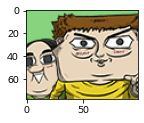

타겟: 마음의소리.png
['야부리맨.png', '데이빗.png', '아이돌 연구소.png', '뱀파이어.png', '대학원 탈출일지.png', '모죠의 일지.png', '수능일기.png', '2022 그걸 네가 왜!.png', '스마일브러시.png', '부활남.png']


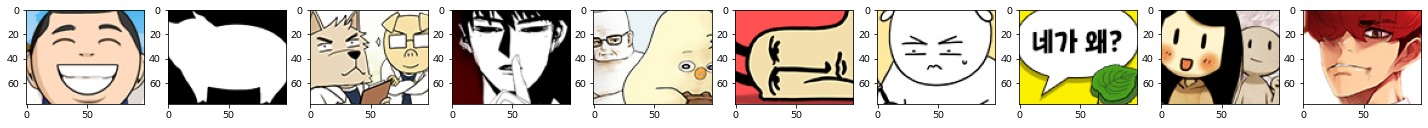

In [ ]:
target = "마음의소리"
target_idx = target_images_names.index(target+".png")
similar_indexes = [idx for idx, _ in images_dist[target_idx][:10]]

plt.figure(figsize=(2,2))
plt.imshow(target_images[target_idx])
plt.show()

print("타겟:", target_images_names[target_idx])
print([target_images_names[idx] for idx in similar_indexes])

plt.figure(figsize=(25,25))
for col in range(10):
    s_idx = similar_indexes[col]
    plt.subplot(1, 10, col+1)
    plt.imshow(target_images[s_idx])

plt.show()